In [1]:
import numpy as np
import pandas as pd
import mne
import os
import logging 

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================
# Set up logging: messages will include timestamp, log level, and message content
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


PREPROCESSED_DATA_ROOT = '../data/preprocessData'
PATH_RESULTS = '../results'
BIDS_TASK_LABEL = '_task-randomDot'
BIDS_BEH_SUFFIX = '_beh'
BIDS_EEG_SUFFIX = '_eeg'

SAMPLING_RATE = 500

CHANNEL_INDICES = [54, 36, 86]

SUBJECT_DIR = [f'sub-A{i:03d}' for i in range(1, 21)]

In [3]:
# =============================================================================
# Data preparation: matrix
# =============================================================================

# Find the maximun rt among all around the trials
PATN_JOINT_MODELING = os.path.join(PATH_RESULTS,'joint-modeling','data_joint_modeling_allSubj.csv')
data_joint_modeling_allSubj = pd.read_csv(PATN_JOINT_MODELING)
MAX_RT_SEC = data_joint_modeling_allSubj['RT'].max()  # Maximum reaction time across all subjects (in seconds)

# Container for all single-trial ERP data
data_single_trials_all = []

for sub_id in SUBJECT_DIR:
    logger.info(f"\nProcessing subject: {sub_id}")

    # === Step 1: Load behavioral data ===
    path_behaviorData = os.path.join(PREPROCESSED_DATA_ROOT, sub_id, 'beh', sub_id+BIDS_TASK_LABEL+BIDS_BEH_SUFFIX+'.tsv')
    data_behavior = pd.read_csv(path_behaviorData, sep='\t', header=0)
    n_behavior_trials = len(data_behavior)
    logger.info(f"  - Behavioral trials: {n_behavior_trials}")
    assert n_behavior_trials > 0, f"No behavioral data found for subject {sub_id}"

    # === Step 2: Load EEG file and relative data ===
    path_eeg = os.path.join(
        PREPROCESSED_DATA_ROOT,
        sub_id,
        'eeg',
        f"{sub_id}{BIDS_TASK_LABEL}{BIDS_EEG_SUFFIX}.vhdr"
    )
    assert os.path.exists(path_eeg), f"EEG file not found: {path_eeg}"

    eeg_bids = mne.io.read_raw_brainvision(path_eeg, preload=False)

    events, event_id = mne.events_from_annotations(eeg_bids)
    event_key_response = 'Stimulus/S  5'
    assert event_key_response in event_id, f"Response event '{event_key_response}' not found in annotations for {sub_id}"
    event_id_response = {event_key_response: event_id[event_key_response]}
    events_response = events[events[:, 2] == event_id_response[event_key_response]]

    data_eeg = eeg_bids.get_data() 
    n_timestamps = data_eeg.shape[1]

    # Compute CPP: average over selected channels
    data_erp = data_eeg[CHANNEL_INDICES, :].mean(axis=0)  # Shape: (n_samples,)

    # Merge behavioral and trigger data
    data_merged_beh_trigger = pd.DataFrame({
        'subject_id': data_behavior['subj'].values,
        'reaction_time_sec': data_behavior['RT'].values,
        'trigger_sample': events_response[:, 0]
    })

    # === step 3: Compute epoch boundaries per trial ===
    # Epoch starts at: trigger - (RT + 0.5 sec) → aligns t = -0.5 sec to stimulus onset
    # Epoch ends at:   trigger + (MAX_RT - RT) → ensures all trials end at same absolute time relative to max RT
    data_merged_beh_trigger['epoch_start_sample'] = np.round(
        np.maximum(0, data_merged_beh_trigger['trigger_sample'] - (data_merged_beh_trigger['reaction_time_sec'] + 0.5) * SAMPLING_RATE)
    ).astype(int)

    data_merged_beh_trigger['epoch_end_sample'] = np.round(
        np.minimum(n_timestamps, data_merged_beh_trigger['trigger_sample'] + (MAX_RT_SEC - data_merged_beh_trigger['reaction_time_sec']) * SAMPLING_RATE)
    ).astype(int)

    # === step 4: Extract ERP segment for each trial ===
    for _, trial_row in data_merged_beh_trigger.iterrows():
        start_idx = trial_row['epoch_start_sample']
        end_idx = trial_row['epoch_end_sample']

        # Get segment erp
        data_erp_segment = data_erp[start_idx:end_idx]

        # Build trial record: metadata + timepoint amplitudes
        data_single_trial = {
            'subject_id': trial_row['subject_id'],
            'reaction_time_sec': trial_row['reaction_time_sec']
        }
        for time_idx, amplitude in enumerate(data_erp_segment):
            data_single_trial[f't_{time_idx}'] = amplitude

        data_single_trials_all.append(data_single_trial)

# Assemble final DataFrame
data_single_trials_all = pd.DataFrame(data_single_trials_all)
print("Final ERP DataFrame shape:", data_single_trials_all.shape)

# === step 5: prepare matrix for plotting
# replace NaNs with 0 (assumes missing ERP samples are negligible)
data_single_trials_all = data_single_trials_all.fillna(0)

# Identify ERP timepoint columns
columns_erp = [col for col in data_single_trials_all.columns if col.startswith('t_')]

# Sort trials by reaction time (longest RT at top of heatmap)
data_single_trials_all_sorted = data_single_trials_all.sort_values('reaction_time_sec', ascending=False).reset_index(drop=True)
data_matrix4plot = data_single_trials_all_sorted[columns_erp].values

2025-12-11 10:47:09,864 - INFO - 
Processing subject: sub-A001
2025-12-11 10:47:09,865 - INFO -   - Behavioral trials: 281


Extracting parameters from ../data/preprocessData/sub-A001/eeg/sub-A001_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:10,620 - INFO - 
Processing subject: sub-A002
2025-12-11 10:47:10,622 - INFO -   - Behavioral trials: 293


Extracting parameters from ../data/preprocessData/sub-A002/eeg/sub-A002_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:11,312 - INFO - 
Processing subject: sub-A003
2025-12-11 10:47:11,314 - INFO -   - Behavioral trials: 280


Extracting parameters from ../data/preprocessData/sub-A003/eeg/sub-A003_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:11,836 - INFO - 
Processing subject: sub-A004
2025-12-11 10:47:11,838 - INFO -   - Behavioral trials: 277


Extracting parameters from ../data/preprocessData/sub-A004/eeg/sub-A004_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:12,329 - INFO - 
Processing subject: sub-A005
2025-12-11 10:47:12,331 - INFO -   - Behavioral trials: 281


Extracting parameters from ../data/preprocessData/sub-A005/eeg/sub-A005_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:12,826 - INFO - 
Processing subject: sub-A006
2025-12-11 10:47:12,827 - INFO -   - Behavioral trials: 306


Extracting parameters from ../data/preprocessData/sub-A006/eeg/sub-A006_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:13,364 - INFO - 
Processing subject: sub-A007
2025-12-11 10:47:13,365 - INFO -   - Behavioral trials: 294


Extracting parameters from ../data/preprocessData/sub-A007/eeg/sub-A007_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:13,962 - INFO - 
Processing subject: sub-A008
2025-12-11 10:47:13,963 - INFO -   - Behavioral trials: 318


Extracting parameters from ../data/preprocessData/sub-A008/eeg/sub-A008_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:14,468 - INFO - 
Processing subject: sub-A009
2025-12-11 10:47:14,470 - INFO -   - Behavioral trials: 262


Extracting parameters from ../data/preprocessData/sub-A009/eeg/sub-A009_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:14,932 - INFO - 
Processing subject: sub-A010
2025-12-11 10:47:14,933 - INFO -   - Behavioral trials: 258


Extracting parameters from ../data/preprocessData/sub-A010/eeg/sub-A010_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:15,420 - INFO - 
Processing subject: sub-A011
2025-12-11 10:47:15,421 - INFO -   - Behavioral trials: 312


Extracting parameters from ../data/preprocessData/sub-A011/eeg/sub-A011_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:15,892 - INFO - 
Processing subject: sub-A012
2025-12-11 10:47:15,893 - INFO -   - Behavioral trials: 285


Extracting parameters from ../data/preprocessData/sub-A012/eeg/sub-A012_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:16,474 - INFO - 
Processing subject: sub-A013
2025-12-11 10:47:16,477 - INFO -   - Behavioral trials: 288


Extracting parameters from ../data/preprocessData/sub-A013/eeg/sub-A013_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:17,043 - INFO - 
Processing subject: sub-A014
2025-12-11 10:47:17,044 - INFO -   - Behavioral trials: 311


Extracting parameters from ../data/preprocessData/sub-A014/eeg/sub-A014_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:17,560 - INFO - 
Processing subject: sub-A015
2025-12-11 10:47:17,562 - INFO -   - Behavioral trials: 299


Extracting parameters from ../data/preprocessData/sub-A015/eeg/sub-A015_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:18,109 - INFO - 
Processing subject: sub-A016
2025-12-11 10:47:18,110 - INFO -   - Behavioral trials: 302


Extracting parameters from ../data/preprocessData/sub-A016/eeg/sub-A016_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:18,696 - INFO - 
Processing subject: sub-A017
2025-12-11 10:47:18,698 - INFO -   - Behavioral trials: 287


Extracting parameters from ../data/preprocessData/sub-A017/eeg/sub-A017_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:19,179 - INFO - 
Processing subject: sub-A018
2025-12-11 10:47:19,180 - INFO -   - Behavioral trials: 261


Extracting parameters from ../data/preprocessData/sub-A018/eeg/sub-A018_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:19,674 - INFO - 
Processing subject: sub-A019
2025-12-11 10:47:19,676 - INFO -   - Behavioral trials: 297


Extracting parameters from ../data/preprocessData/sub-A019/eeg/sub-A019_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-11 10:47:20,285 - INFO - 
Processing subject: sub-A020
2025-12-11 10:47:20,287 - INFO -   - Behavioral trials: 276


Extracting parameters from ../data/preprocessData/sub-A020/eeg/sub-A020_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Final ERP DataFrame shape: (5768, 1480)


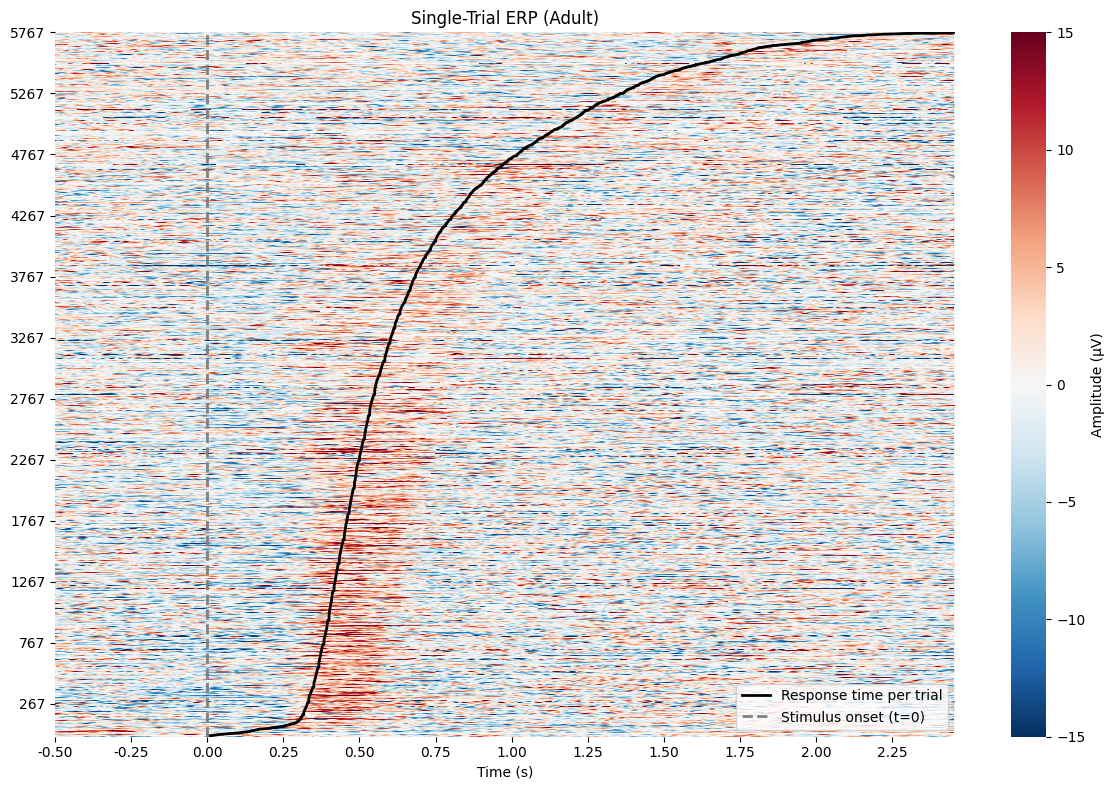

In [5]:
# =============================================================================
# Plot single trial plot
# =============================================================================

n_trials, n_timestamps = data_matrix4plot.shape

# === step 1: Create heatmap ===
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    data_matrix4plot,
    cmap='RdBu_r',
    center=0,
    xticklabels=False,
    yticklabels=False,
    vmin=-15,
    vmax=15,
    cbar_kws={'label': 'Amplitude (µV)'}
)

# === step 2: Reaction time trajectory ===
data_rt_array = data_single_trials_all_sorted['reaction_time_sec'].to_numpy()
# Time axis: t = -0.5 sec corresponds to column index 0
# Therefore, RT (relative to stimulus) occurs at: t = RT → column = (RT + 0.5) * sampling_rate
positions_rt_x = (data_rt_array + 0.5) * SAMPLING_RATE
positions_rt_y = np.arange(n_trials)
ax.plot(positions_rt_x, positions_rt_y, color='black', linewidth=2, label='Response time per trial')

# === step 3: Set x-axis time labels ===
# Total duration covered: from t = -0.5 sec to t = (n_timestamps / SAMPLING_RATE) - 0.5 sec
time_vector_sec = np.arange(-0.5, (n_timestamps / SAMPLING_RATE) - 0.5 + 1e-9, 0.25)
x_tick_indices = ((time_vector_sec + 0.5) * SAMPLING_RATE).astype(int)

# Ensure indices are within bounds
valid_ticks = (x_tick_indices >= 0) & (x_tick_indices < n_timestamps)
ax.set_xticks(x_tick_indices[valid_ticks])
ax.set_xticklabels([f"{t:.2f}" for t in time_vector_sec[valid_ticks]])

# === step 3: Set y-axis trial labels ===
y_tick_step = 500
y_tick_positions = np.arange(0, n_trials, y_tick_step)

# For correct visual alignment with "trial 0 at bottom",
# we plot y = n_trials - 1 - i, but since we want labels to reflect actual trial order from bottom,
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(n_trials - 1 - y_tick_positions)  # Trial index as shown (0 = first row = top)

# === step 4: Mark stimulus onset (t = 0) ===
t0_column_index = int(0.5 * SAMPLING_RATE) 
ax.axvline(x=t0_column_index, color='grey', linewidth=2, linestyle='--', label='Stimulus onset (t=0)')

# === step 5: Finalize plot ===
ax.set_xlabel('Time (s)')
ax.set_title('Single-Trial ERP (Adult)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()